# Preprocessing and modelling

## Preparations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/leonardoblas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/leonardoblas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
history = pd.read_csv("../data/history.csv")
alternative_history = pd.read_csv("../data/alternative_history.csv")

## Columns of interest

In [3]:
columns_to_keep = [
    "subreddit",
    "selftext",
    "gilded",
    "title",
    "thumbnail_height",
    "upvote_ratio",
    "score",
    "edited",
    "is_self",
    "created",
    "domain",
    "allow_live_comments",
    "no_follow",
    "locked",
    "author",
    "num_comments",
    "send_replies",
    "num_crossposts"
]

In [4]:
numeric_columns = [
    "gilded",
    "upvote_ratio",
    "score",
    "num_comments",
    "num_crossposts"
]

## Droppers

In [5]:
history_dropper = ColumnTransformer(
    [("dropper", "drop", [column for column in history.columns if column not in columns_to_keep])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

In [6]:
alternative_history_dropper = ColumnTransformer(
    [("dropper", "drop", [column for column in alternative_history.columns if column not in columns_to_keep])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

## Transformers

### `selftext`, `title`, `domain`, and `author`

We feature engineer a `text` column by appending these columns.

In [7]:
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["text"] =  X["title"] + X["domain"].fillna("") + X["author"].fillna("") + X["selftext"].fillna("")
        X.drop(inplace=True, columns=["selftext", "title", "domain", "author"])
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [8]:
text_transformer = ColumnTransformer(
    [("text_transformer", TextTransformer(), ["selftext", "title", "domain", "author"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

### `thumbnail_height`

We decided to convert this numeric column, with some null-values, to a nominal column, where 1 means the post has a thumbnail, and 0 means it does not.

In [9]:
class ThumbnailHeightTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.rename(inplace=False, columns={"thumbnail_height": "has_thumbnail"}).notna()

    def set_output(self, transform):
        self.output_format = transform
        return self

In [10]:
thumbnail_height_transformer = ColumnTransformer(
    [("thumbnail_height_transformer", ThumbnailHeightTransformer(), ["thumbnail_height"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

### `edited`

We convert this numeric column, with some `False` and some UNIX time values, to a nominal column, where 1 means the post was edited and 0 means it was not.

In [11]:
class EditedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["edited"] = X["edited"] != "False"
        return X
        
    def set_output(self, transform):
        self.output_format = transform
        return self

In [12]:
edited_transformer = ColumnTransformer(
    [("edited_transformer", EditedTransformer(), ["edited"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

### `created`

We transform `created`'s UNIX times to a stage in the day, like morning or late night.

In [13]:
class CreatedTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.copy()
        X["created"] = pd.to_datetime(X["created"], unit="s").dt.hour
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [14]:
created_transformer = ColumnTransformer(
    [("created_transformer", CreatedTransformer(), ["created"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

Next, we encode our transformed column.

In [15]:
created_encoder = ColumnTransformer(
    [("created_encoder", OneHotEncoder(drop="first", sparse_output=False, categories=[[i for i in range(24)]]), ["created"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

In [16]:
created_pipeline = Pipeline([
    ("created_transformer", created_transformer),
    ("created_encoder", created_encoder)
]).set_output(transform="pandas")

## NLP on `text`

### Lowercaser

In [17]:
class Lowercaser(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X["text"] = X["text"].str.lower()
        return X

    def set_output(self, transform):
        self.output_format = transform
        return self

In [18]:
lowercaser = ColumnTransformer(
    [("lowercaser", Lowercaser(), ["text"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

### Lemmatizer

In [19]:
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        word_net_lemmatizer = WordNetLemmatizer()
        X = X.copy()
        X["text"] = X["text"].apply(lambda x: " ".join([word_net_lemmatizer.lemmatize(w) for w in word_tokenize(x)]))
        return X
        
    def set_output(self, transform):
        self.output_format = transform
        return self

In [20]:
lemmatizer = ColumnTransformer(
    [("lemmatizer", Lemmatizer(), ["text"])],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

### Vectorizer

Due to the nature of the assignment--we want our lemmatized tokens to be weighted--we use a TFIDF vectorizer. Additionally, due to our lack of computational power, we use unigrams and bigrams and no `max_features`.

In [21]:
class Vectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, output_format="pandas"):
        self.output_format = output_format
        self.vectorizer = None
        
    def fit(self, X, y=None):
        self.vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1, 2))
        self.vectorizer.fit(X["text"])
        return self
    
    def transform(self, X):
        X = X.copy()
        vectorized = self.vectorizer.transform(X["text"])
        vectorized = pd.DataFrame(vectorized.toarray(), columns=self.vectorizer.get_feature_names_out())
        X.drop(inplace=True, columns=["text"])
        return vectorized
        
    def set_output(self, transform):
        self.output_format = transform
        return self

In [22]:
vectorizer = ColumnTransformer(
    [("vectorizer", Vectorizer(), ["text"])],
    remainder="passthrough", verbose_feature_names_out=True
).set_output(transform="pandas")

### NLP pipeline

In [23]:
nlp_pipeline = Pipeline([
    ("text_transformer", text_transformer),
    ("lowercaser", lowercaser),
    ("lemmatizer", lemmatizer),
    ("vectorizer", vectorizer)
]).set_output(transform="pandas")

## Scaler

In [24]:
scaler = ColumnTransformer(
    [("scaler", StandardScaler(), numeric_columns)],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

## Normalizer

In [25]:
normalizer = ColumnTransformer(
    [("normalizer", PowerTransformer(), numeric_columns)],
    remainder="passthrough", verbose_feature_names_out=False
).set_output(transform="pandas")

## Homogeneizing `history` and `alternative_history`'s features

In [26]:
history = history_dropper.fit_transform(history)
alternative_history = alternative_history_dropper.fit_transform(alternative_history)

## Train test split

In [27]:
history_X_train, history_X_test, history_y_train, history_y_test = train_test_split(history.drop(columns=["subreddit"]), history["subreddit"], random_state=42)
alternative_history_X_train, alternative_history_X_test, alternative_history_y_train, alternative_history_y_test = train_test_split(alternative_history.drop(columns=["subreddit"]), alternative_history["subreddit"], random_state=42)

## Dropping training rows with numeric outliers

Dropping numeric values past 4 standard deviations.

In [28]:
def get_outlier_indices(column):
    z_scores = np.abs((column - column.mean()) / column.std())
    outlier_indices = set(z_scores[z_scores > 4].index)
    return outlier_indices

In [29]:
history_outlier_indices = set()
for column in history_X_train.select_dtypes(include=["number"]).columns:
    history_outlier_indices = history_outlier_indices | get_outlier_indices(history_X_train[column])
alternative_history_outlier_indices = set()
for column in alternative_history_X_train.select_dtypes(include=["number"]).columns:
    alternative_history_outlier_indices = alternative_history_outlier_indices | get_outlier_indices(alternative_history_X_train[column])

In [30]:
history_X_train.drop(history_outlier_indices, inplace=True)
history_y_train.drop(history_outlier_indices, inplace=True)
alternative_history_X_train.drop(alternative_history_outlier_indices, inplace=True)
alternative_history_y_train.drop(alternative_history_outlier_indices, inplace=True)

## Combining history and alternative history entries

In [31]:
X_train = pd.concat([history_X_train, alternative_history_X_train], axis=0)
y_train = pd.concat([history_y_train, alternative_history_y_train], axis=0)
X_test = pd.concat([history_X_test, alternative_history_X_test], axis=0)
y_test = pd.concat([history_y_test, alternative_history_y_test], axis=0)

## Resetting indices

Because we combined the datasets, dropped outliers, and will use vectorizers, we need to reset our indices.

In [32]:
X_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Preprocessor

Note that `nlp_pipeline` must be the final step in our `preprocessor`, because our TFIDF vectorizer needs `verbose_names_out=True`, and changing the names of some columns, like `score` will affect steps like scaling or normalizing.

In [33]:
preprocessor = Pipeline([
    ("thumbnail_height_transformer", thumbnail_height_transformer),
    ("edited_transformer", edited_transformer),
    ("created_pipeline", created_pipeline),
    ("scaler", scaler),
    ("normalizer", normalizer),
    ("nlp_pipeline", nlp_pipeline)
]).set_output(transform="pandas")

## Preprocessing

In [34]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Modelling

### Logistic regression

In [35]:
logistic_regressor = LogisticRegression()

In [36]:
logistic_regressor.fit(X_train, y_train)

LogisticRegression()

In [37]:
logistic_regressor.score(X_train, y_train)

0.9503083061298513

In [38]:
logistic_regressor.score(X_test, y_test)

0.9094693028095734

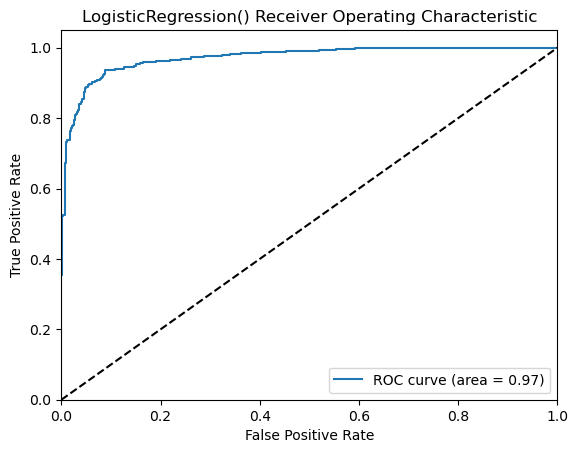

In [39]:
y_pred_proba = logistic_regressor.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="history")
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LogisticRegression() Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("../images/logistic_regression_roc.png", bbox_inches="tight");

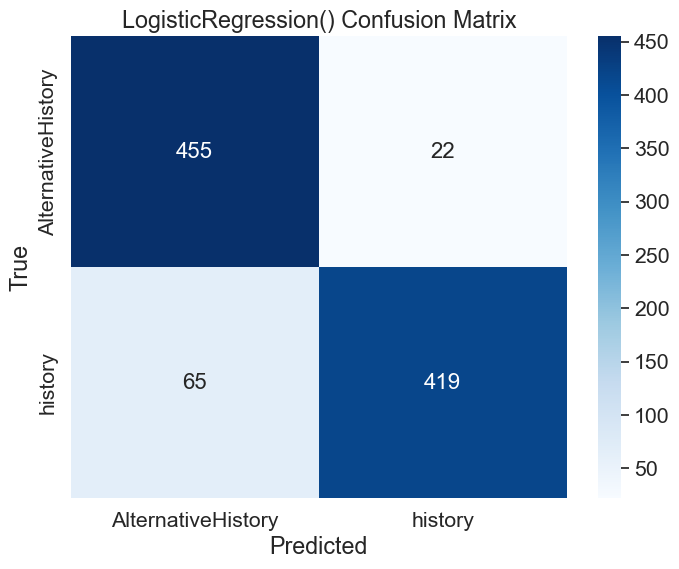

In [40]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, logistic_regressor.predict(X_test)), annot=True, annot_kws={"size": 16}, fmt="g", cmap="Blues",
            xticklabels=logistic_regressor.classes_, yticklabels=logistic_regressor.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LogisticRegression() Confusion Matrix")
plt.savefig("../images/logistic_regression_confusion_matrix.png", bbox_inches="tight");

### Random forest classifying

In [41]:
random_forest_classifier = RandomForestClassifier()

In [42]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
random_forest_classifier.score(X_train, y_train)

1.0

In [44]:
random_forest_classifier.score(X_test, y_test)

0.951092611862643

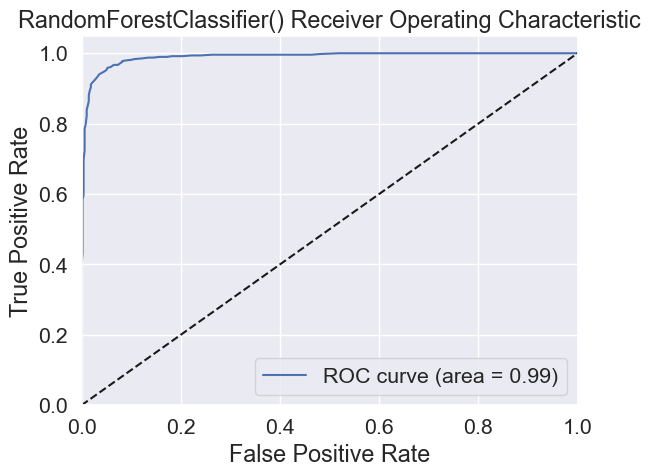

In [45]:
y_pred_proba = random_forest_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="history")
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RandomForestClassifier() Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("../images/random_forest_roc.png", bbox_inches="tight");

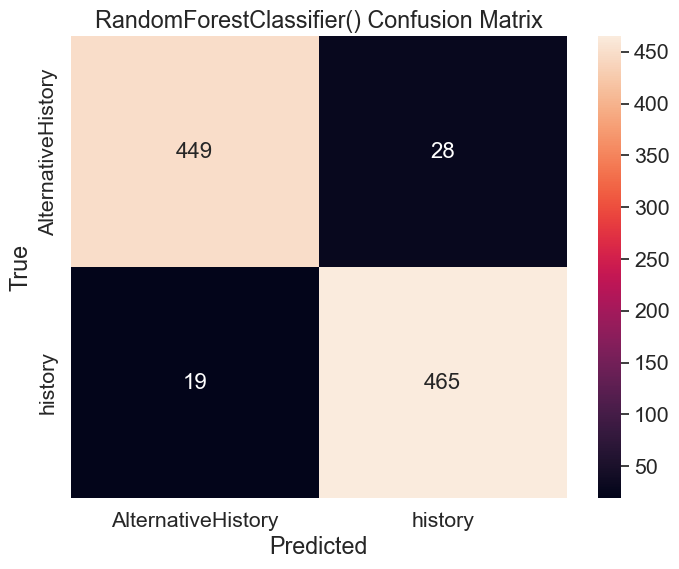

In [46]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, random_forest_classifier.predict(X_test)), annot=True, annot_kws={"size": 16}, fmt="g", 
            xticklabels=random_forest_classifier.classes_, yticklabels=random_forest_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("RandomForestClassifier() Confusion Matrix")
plt.savefig("../images/random_forest_confusion_matrix.png", bbox_inches="tight");

### Naive Bayes classifying

In [47]:
gaussian_nb = GaussianNB()

In [48]:
gaussian_nb.fit(X_train, y_train)

GaussianNB()

In [49]:
gaussian_nb.score(X_train, y_train)

1.0

In [50]:
gaussian_nb.score(X_test, y_test)

0.7887617065556711

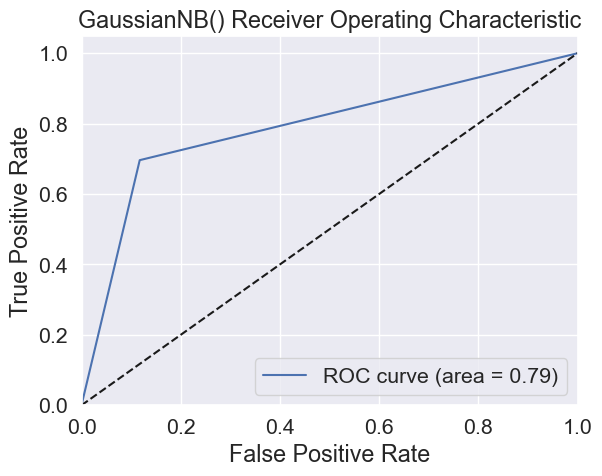

In [51]:
y_pred_proba = gaussian_nb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="history")
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GaussianNB() Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("../images/naive_bayes_roc.png", bbox_inches="tight");

In [52]:
confusion_matrix(y_test, random_forest_classifier.predict(X_test))

array([[449,  28],
       [ 19, 465]])

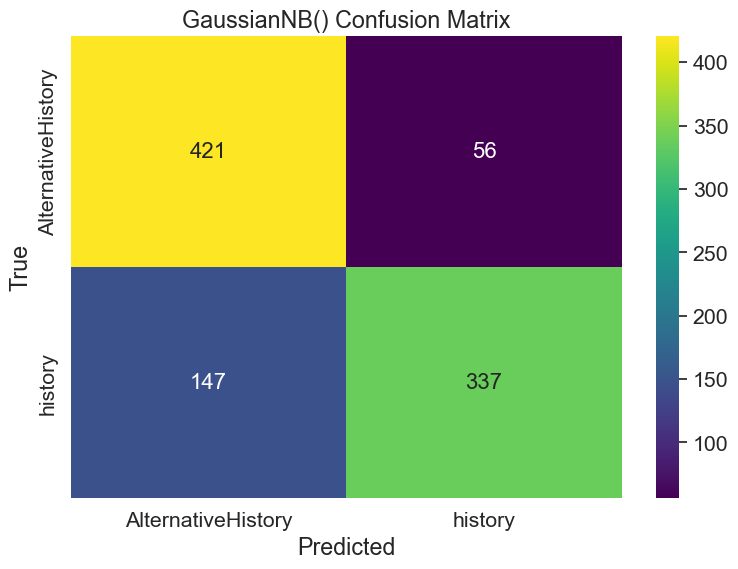

In [53]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, gaussian_nb.predict(X_test)), annot=True, annot_kws={"size": 16}, fmt="g", cmap="viridis",
            xticklabels=gaussian_nb.classes_, yticklabels=gaussian_nb.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GaussianNB() Confusion Matrix")
plt.tight_layout()
plt.savefig("../images/naive_bayes_confusion_matrix.png", bbox_inches="tight");

### Time of the day as predictor

#### Preparing the data

In [54]:
history_time_of_day = history[["created", "subreddit"]]
history_time_of_day = created_pipeline.fit_transform(history_time_of_day)

In [55]:
alternative_history_time_of_day = alternative_history[["created", "subreddit"]]
alternative_history_time_of_day = created_pipeline.fit_transform(alternative_history_time_of_day)

In [56]:
time_of_day = pd.concat([history_time_of_day, alternative_history_time_of_day], axis=0)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(time_of_day.drop(columns=["subreddit"]), time_of_day["subreddit"], random_state=42)

#### Visualizing

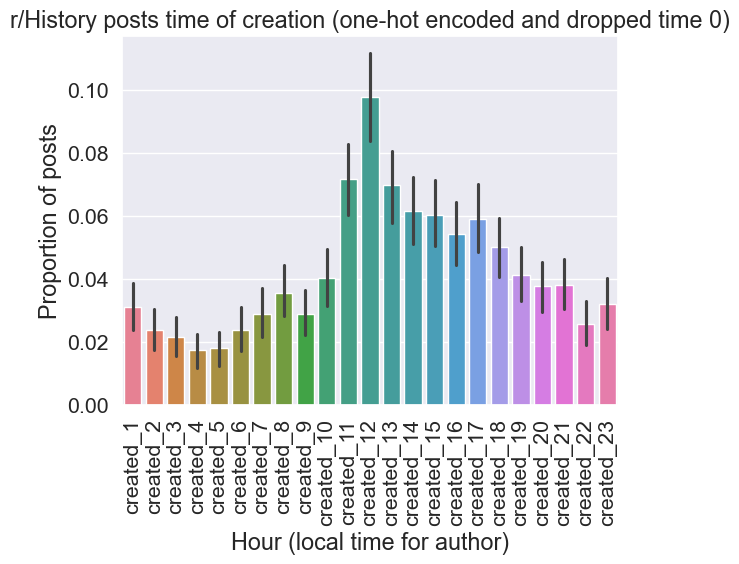

In [58]:
sns.barplot(history_time_of_day)
plt.title("r/History posts time of creation (one-hot encoded and dropped time 0)")
plt.xlabel("Hour (local time for author)")
plt.ylabel("Proportion of posts")
plt.xticks(rotation=90)
plt.savefig("../images/history_creation_time.png", bbox_inches="tight");

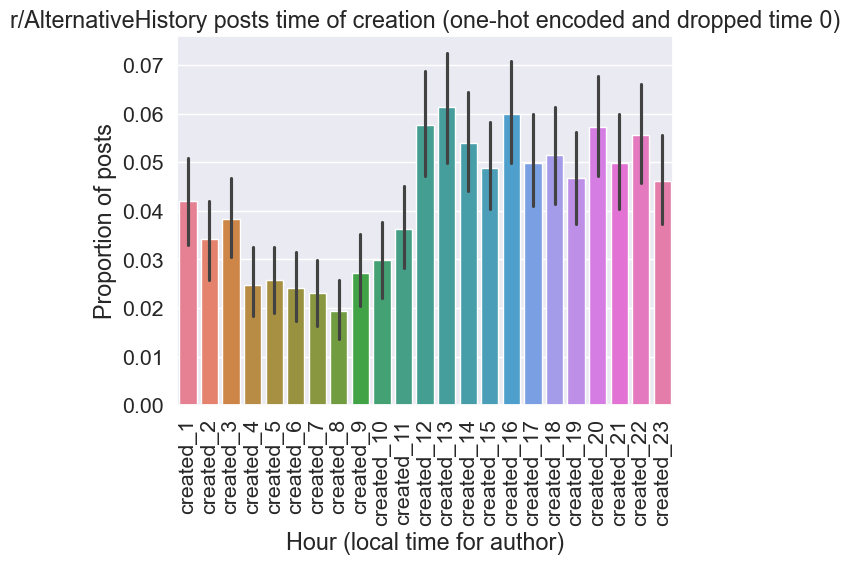

In [59]:
sns.barplot(alternative_history_time_of_day)
plt.title("r/AlternativeHistory posts time of creation (one-hot encoded and dropped time 0)")
plt.xlabel("Hour (local time for author)")
plt.ylabel("Proportion of posts")
plt.xticks(rotation=90)
plt.savefig("../images/alternative_history_creation_time.png", bbox_inches="tight");

#### Logistic regression

In [60]:
logistic_regressor = LogisticRegression()

In [61]:
logistic_regressor.fit(X_train, y_train)

LogisticRegression()

In [62]:
logistic_regressor.score(X_train, y_train)

0.5725694444444445

In [63]:
logistic_regressor.score(X_test, y_test)

0.5697916666666667

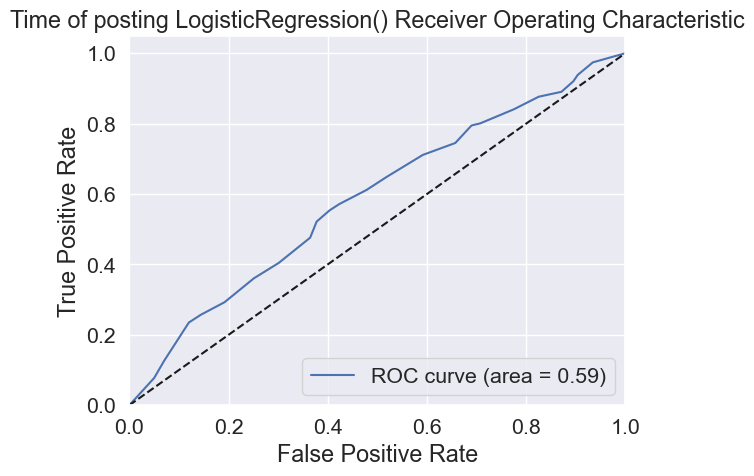

In [64]:
y_pred_proba = logistic_regressor.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="history")
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Time of posting LogisticRegression() Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("../images/time_logistic_regression_roc.png", bbox_inches="tight");

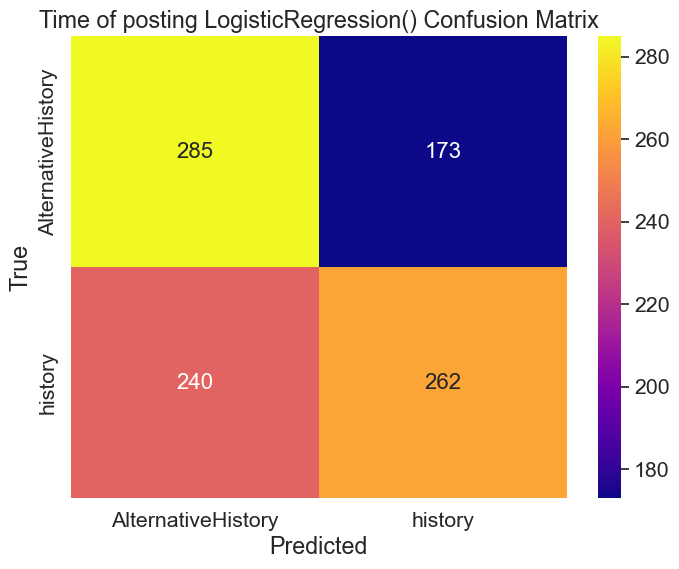

In [65]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, logistic_regressor.predict(X_test)), annot=True, annot_kws={"size": 16}, fmt="g", cmap="plasma",
            xticklabels=logistic_regressor.classes_, yticklabels=logistic_regressor.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Time of posting LogisticRegression() Confusion Matrix")
plt.savefig("../images/time_logistic_regression_confusion_matrix.png", bbox_inches="tight");

#### Random forest classifying

In [66]:
random_forest_classifier = RandomForestClassifier()

In [67]:
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [68]:
random_forest_classifier.score(X_train, y_train)

0.5725694444444445

In [69]:
random_forest_classifier.score(X_test, y_test)

0.5739583333333333

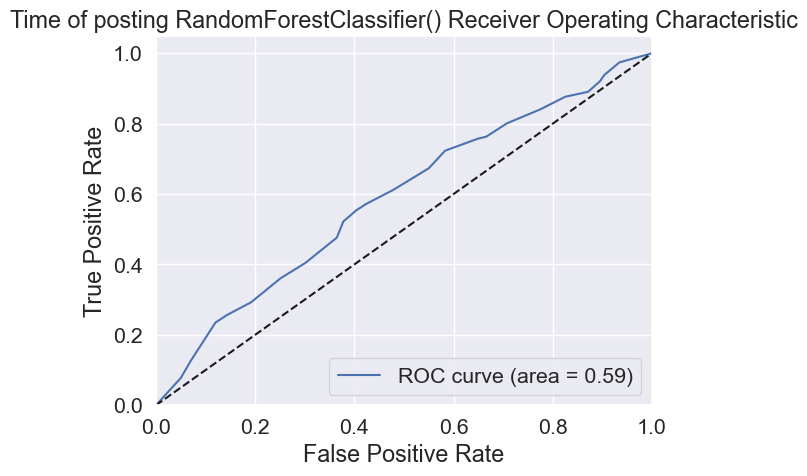

In [70]:
y_pred_proba = random_forest_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label="history")
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Time of posting RandomForestClassifier() Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("../images/time_random_forest_roc.png", bbox_inches="tight");

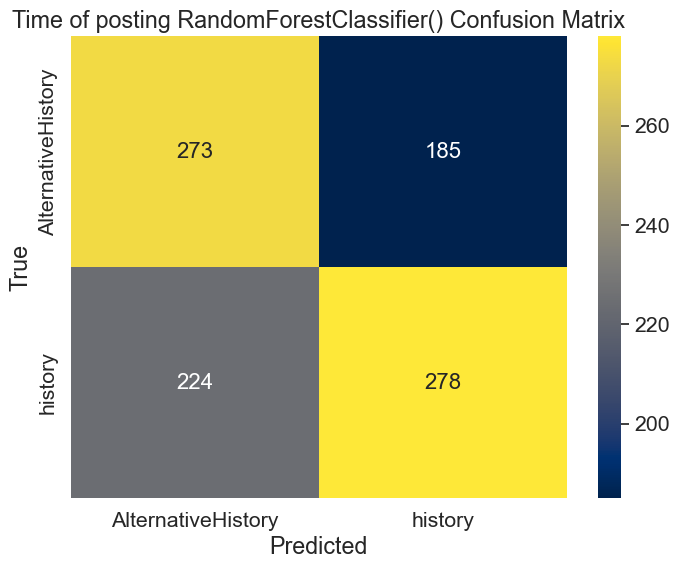

In [71]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, random_forest_classifier.predict(X_test)), annot=True, annot_kws={"size": 16}, fmt="g", cmap="cividis", 
            xticklabels=random_forest_classifier.classes_, yticklabels=random_forest_classifier.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Time of posting RandomForestClassifier() Confusion Matrix")
plt.savefig("../images/time_random_forest_confusion_matrix.png", bbox_inches="tight");